# Task 3:  Three-class semantic segmentation

In this task we will attempt to solve the problem of animal segmentation with three classes: "background" (label 0), "cat" (label 1) and "dog" (label 2).

<!-- ![Image](https://miro.medium.com/max/1130/1*DDEkOFC93pEbrTdyhdpXZg.png) -->
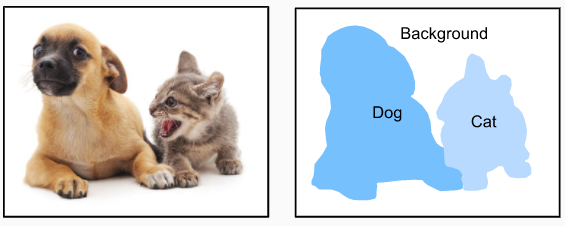

To do this, we will prepare a [dataset](https://drive.google.com/file/d/14QfXAJjEPP9qedOq2toGmJ_HpRjAA7tm/view?usp=sharing), implement metrics/loss functions, implement and train our [PSPNet](https://arxiv.org/abs/1612.01105)-like model.

In [2]:
import gdown

In [3]:
!gdown --id 14QfXAJjEPP9qedOq2toGmJ_HpRjAA7tm

/home/coder/.conda/envs/gym/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14QfXAJjEPP9qedOq2toGmJ_HpRjAA7tm
From (redirected): https://drive.google.com/uc?id=14QfXAJjEPP9qedOq2toGmJ_HpRjAA7tm&confirm=t&uuid=0ddec01a-3474-4928-ae91-ffd0ec49d277
To: /home/coder/project/Segmentation_Task/SegmentationTask_data.zip
100%|████████████████████████████████████████| 815M/815M [00:09<00:00, 82.6MB/s]


In [4]:
!unzip SegmentationTask_data.zip

Archive:  SegmentationTask_data.zip
  inflating: SegTask/trainval.txt    
  inflating: SegTask/test.txt        
  inflating: SegTask/images/17e77040.jpg  
  inflating: SegTask/images/48978a00.jpg  
  inflating: SegTask/images/05949a8b.jpg  
  inflating: SegTask/images/5f5c20b2.jpg  
  inflating: SegTask/images/573e1d0b.jpg  
  inflating: SegTask/images/9d3b3cea.jpg  
  inflating: SegTask/images/08bb728b.jpg  
  inflating: SegTask/images/a804d96e.jpg  
  inflating: SegTask/images/79daa4b8.jpg  
  inflating: SegTask/images/1d8a0689.jpg  
  inflating: SegTask/images/486bc4ee.jpg  
  inflating: SegTask/images/741e4f6e.jpg  
  inflating: SegTask/images/cf426787.jpg  
  inflating: SegTask/images/8757ce63.jpg  
  inflating: SegTask/images/fe98abc5.jpg  
  inflating: SegTask/images/d4902a62.jpg  
  inflating: SegTask/images/2518126c.jpg  
  inflating: SegTask/images/f73b96cd.jpg  
  inflating: SegTask/images/62fa02e2.jpg  
  inflating: SegTask/images/a6088fac.jpg  
  inflating: SegTask/images/

### Module Imports

In [2]:
# import pytorch to work with neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

# for working with images/graphics
from torchvision import transforms
# import image interpolation methods
from torchvision.transforms.functional import InterpolationMode as IM
import matplotlib.pyplot as plt

# for logging metrics and loss functions during training
import wandb

# for convenient work with train/test samples
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# other
import numpy as np
from tqdm import tqdm
import h5py
import numpy as np
import os
from PIL import Image
from PIL.Image import Image as Image_t
from abc import ABC, abstractmethod
from typing import Type, Union

Utils

In [3]:
class storage_class(ABC):
    def __init__(self, config: dict):
        self.config = config
        self.pos = 0
        self.__locked = False
        
    @property
    @abstractmethod
    def dataset_size(self) -> int:
        """
        Return the number of pairs (image, segmentation mask) in the dataset
        """
        pass
    
    @abstractmethod
    def append(self, input_chunk: np.array, target_chunk: np.array) -> None:
        """
        Add a block of images `input_chunk` and a block of masks `target_chunk` to the dataset
        """
        pass
    
    @abstractmethod
    def lock(self) -> None:
        """
        Close write mode, open in read mode
        """
        pass
    
    @abstractmethod
    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        """
        Return pair (image, mask) at index `idx`
        """
        pass

    
class storage_hdf5(storage_class):
    def __init__(self, config):
        super().__init__(config)
        
        self.dataset = h5py.File(f'{config["annotation_file"].rstrip(".txt")}.h5', 'a')
        try:
            self.dataset.create_dataset("input", shape=(config["dataset_size"], *config["target_shape"], 3), dtype=np.uint8)
        except ValueError:
            pass
        try:
            self.dataset.create_dataset("target",  shape=(config["dataset_size"], *config["target_shape"]), dtype=np.uint8)
        except ValueError:
            pass

    @property
    def dataset_size(self):
        assert self.dataset["input"].shape[:-1] == self.dataset["target"].shape
        assert self.dataset["target"].shape[0] == self.config["dataset_size"]
        return self.config["dataset_size"]
    
    def append(self, input_chunk, target_chunk):
        l_idx = self.pos * self.config["chunk_size"]
        r_idx = min(self.config["dataset_size"], l_idx + self.config["chunk_size"])
        self.dataset["input"][l_idx:r_idx] = input_chunk[:r_idx-l_idx]
        self.dataset["target"][l_idx:r_idx] = target_chunk[:r_idx-l_idx]
        self.pos += 1
    
    def lock(self):
        self.dataset.close()
        self.dataset = h5py.File(f'{self.config["annotation_file"].rstrip(".txt")}.h5', 'r')
        self.__locked = True
    
    def __getitem__(self, idx):
        if not(self.__locked):
            raise AttributeError("HDF5 file is not locked. Access denied.")
        return Image.fromarray(self.dataset["input"][idx]), Image.fromarray(self.dataset["target"][idx])

    
class storage_memmap(storage_class):
    def __init__(self, config):
        super().__init__(config)
        
        path = config["annotation_file"].rstrip(".txt")
        os.makedirs(path, exist_ok=True)
        self.input_path = os.path.join(path, "input.npy")
        self.target_path = os.path.join(path, "target.npy")

        self.input = np.memmap(
            self.input_path, mode='w+', dtype=np.uint8,
            shape=(config["dataset_size"], *config["target_shape"], 3)
        )
        self.target = np.memmap(
            self.target_path, mode='w+', dtype=np.uint8,
            shape=(config["dataset_size"], *config["target_shape"])
        )
    
    @property
    def dataset_size(self):
        assert self.input.shape[:-1] == self.target.shape
        assert self.input.shape[0] == self.config["dataset_size"]
        return self.config["dataset_size"]
                                 
    def append(self, input_chunk, target_chunk):
        l_idx = self.pos * self.config["chunk_size"]
        r_idx = min(self.config["dataset_size"], l_idx + self.config["chunk_size"])
        self.input[l_idx:r_idx] = input_chunk[:r_idx-l_idx]
        self.target[l_idx:r_idx] = target_chunk[:r_idx-l_idx]
        self.pos += 1
    
    def lock(self):
        del self.input
        del self.target
        self.input = np.memmap(
            self.input_path, mode='r', dtype=np.uint8,
            shape=(self.config["dataset_size"], *self.config["target_shape"], 3)
        )
        self.target = np.memmap(
            self.target_path, mode='r', dtype=np.uint8,
            shape=(self.config["dataset_size"], *self.config["target_shape"])
        )
        self.__locked = True
    
    def __getitem__(self, idx):
        if not(self.__locked):
            raise AttributeError("Memory-mapped file is not locked. Access denied.")
        return Image.fromarray(self.input[idx]), Image.fromarray(self.target[idx])

    
class storage_raw(storage_class):
    def __init__(self, config):
        super().__init__(config)
                                 
        path = config["annotation_file"].rstrip(".txt")
        self.input_path = os.path.join(path, "Input")
        self.target_path = os.path.join(path, "Target")
        self.idx2input = lambda idx: os.path.join(self.input_path, f"input{idx}.jpg")
        self.idx2target = lambda idx: os.path.join(self.target_path, f"target{idx}.png")
        
        os.makedirs(path, exist_ok=True)
        os.makedirs(self.input_path, exist_ok=False)
        os.makedirs(self.target_path, exist_ok=False)
    
    @property
    def dataset_size(self):
        assert len(os.listdir(self.input_path)) == len(os.listdir(self.target_path))
        assert len(os.listdir(self.input_path)) == self.config["dataset_size"]
        return self.config["dataset_size"]
                                 
    def append(self, input_chunk, target_chunk):
        l_idx = self.pos * self.config["chunk_size"]
        r_idx = min(self.config["dataset_size"], l_idx + self.config["chunk_size"])
                                 
        for idx in range(l_idx, r_idx):
            Image.fromarray(input_chunk[idx-l_idx], "RGB").save(self.idx2input(idx))
            Image.fromarray(target_chunk[idx-l_idx], 'L').save(self.idx2target(idx))

        self.pos += 1
                                 
    def lock(self):
        self.__locked = True
                                 
    def __getitem__(self, idx):
        if not(self.__locked):
            raise AttributeError("Raw file is not locked. Access denied.")
        input = Image.open(self.idx2input(idx)).convert("RGB")
        target = Image.open(self.idx2target(idx)).convert('L')
        return input, target


def renumerate_target(target: np.array, label: int) -> np.array:
    """
    Renumber the segmentation masks.
    In the original dataset the following labels are `{1: object, 2: background, 3: ignore_index}`,
    where object is determined by the value of the variable `label` from the set {1(cat), 2(dog)}.
    We cast the values to a single format {0: background, 1: cat, 2: dog, 255: ignore_index}.
    `ignore_index` corresponds to mask pixels that are not included in the calculation of
    quality metrics (these are the outlines of objects that are difficult to accurately predict)
    """
    target_map = {1: label, 2: 0, 3: 255}
    indexer = np.array(list(target_map.values()))
    target = indexer[(target - target.min())]
    return target


def colorize(data):
    color_map = {
        0: np.array([0, 0, 0]),  # black
        1: np.array([0, 0, 255]),  # blue
        2: np.array([255, 0, 0]),  # red
        255: np.array([255, 255, 255])  # white
    }
            
    return np.array([color_map[pixel] for pixel in data.ravel()]).reshape(*data.shape, 3)


# Function for drawing pictures
def draw(pair: tuple[torch.tensor, torch.tensor], t_dict: dict, prediction: torch.tensor = None, log: bool = False):
    """
    `pair` contains a pair (image, segmentation mask)
    `prediction` contains the segmentation mask predicted by the model
    `log` flag for requiring logging in tensorboard
    """
    input, target = pair
    num_images = 3
    if (prediction is None):
        num_images = 2
    
    f, ax = plt.subplots(1, num_images, figsize=(8*num_images, 8))
    ax[0].imshow(t_dict["backward_input"](input))
    ax[0].axis('off')
    ax[1].imshow(colorize(t_dict["backward_target"](target)))
    ax[1].axis('off')

    if not(prediction is None):
        prediction[target == 255] = 255
        ax[2].imshow(colorize(t_dict["backward_target"](prediction)))
        ax[2].axis('off')
        
    plt.tight_layout()
    if (log):
        return f
    plt.show()


In [4]:
np.random.binomial(1, 0.5)

1

## Part 1: Data preparation

### 1.1 Dataset preparation (1 point)

Let's apply the implemented transformations and make sure they work:

To start working with data, we need to complete the following steps:
- Decide on the method of storing/reading data from the disk. In computer vision tasks, datasets are usually large in size and do not fit into RAM. Therefore, several storage formats are used: `HDF5`, `memory-mapped files` and `"raw"` view, i.e. storing `.jpg/.png` files on disk. Classes with the specified methods are already described in the `utils.py` file. You are only asked to measure the data reading speed for each format and then select the fastest one (a little later).
    - Let's talk in more detail about the features of these storage formats. The `hdf5` format allows you to split arrays of information into [chunks](https://www.oreilly.com/library/view/python-and-hdf5/9781491944981/ch04.html), which are organized in the form of B-trees. This makes sense when reading `hyperslabs` - multi-dimensional array slices that are non-contiguous in memory. By default, `hdf5` stores data contiguously.
   - `Memory-mapping` files into RAM allows you to skip the buffering stage, thereby skipping the copy operation, lazily loading information directly. The peculiarity of this approach is that algorithmically the `Best case` of reading speed is achieved on a contiguous block of information, and the `Worst case` - on the contrary, on a non-contiguous block in memory (orders of magnitude worse than potentially possible in `hdf5`).

- Convert all pairs (image, mask) to a single size `target_shape`, specified further in the configuration dictionary `default_config`. The following sequence of actions is suggested:
    1. Using [transforms.Resize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) we can interpolate (bilinear interpolation by default) pixel values when resizing the original image to a given size. However, such an operation distorts the original aspect ratio of the image, which can negatively affect the predictive ability of the network. For example, the overall appearance of a cat's face will depend on the original size of the image, and not on the entity of the "cat" class: it may not be stretched, it may be stretched vertically/horizontally. Inconsistency in the representation of the same entity can lead to unstable learning, since the dimensions of the convolution kernel are the same for any input image! Fortunately, this problem has already been solved in `transforms.Resize`: given an integer argument `size`, the smallest side of the input image will be interpolated to `size`, and the other side (largest) to `size * aspect_ratio`, i.e. maintaining the ratio sides `aspect_ratio`
    2. Currently, only one side of the source image matches the required `target_shape` size. There are two possible cases: the remaining side is smaller or larger (the case with equality can be reduced to the situation “smaller by 0”) than the required size. In the first case, we will supplement the image with pixels with the value `pad_value` using [transforms.Pad](https://pytorch.org/vision/stable/generated/torchvision.transforms.Pad.html#torchvision.transforms.Pad), in the second case we will crop the image using transforms.CenterCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.CenterCrop.html#torchvision.transforms.CenterCrop).
> Sequential execution of the operations of the `transforms` module can be done using [transforms.Compose](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html).
- Answer the question: `Why, in general, is it necessary to convert all images to the same size?`

Your answer: ...

In [5]:
def resize(img: Image_t, target_shape: tuple[int, int], pad_val: int) -> np.array:
    """
    Converts an input image `img` to the size `target_shape`, using
    the sequence of operations stated above. The required size of `target_shape` is assumed to be "square".
    """
    # Check the equality of the image sides
    assert target_shape[0] == target_shape[1]

    # Necessary for "universality" in determining the number of missing padding pixels.
    # If the dimension of the current image is less than the required one,
    # we have a non-negative number of missing padding pixels, relu returns this number unchanged.
    # If the dimension of the current image is greater than the required one,
    # we have a negative number of missing padding pixels,
    # i.e. we don’t need padding pixels and relu returns the value 0.
    def relu(x):
        return x * (x > 0)

    # We scale the smallest dimension of `img` to `target_shape` as an interpolation method.
    # As an interpolation method, we will choose interpolation using the nearest neighbor method.
    # This is necessary to save multiple segmentation mask values
    img = transforms.Resize(target_shape[0], interpolation=IM.NEAREST)(img)

    # Calculate the number of missing padding pixels for each side of the image
    w, h = img.size
    h_diff, w_diff = target_shape[0] - h, target_shape[1] - w

    pad_left, pad_right = w_diff //2, w_diff - w_diff // 2
    pad_top, pad_bottom = h_diff // 2, h_diff - h_diff // 2

    resize_transform = transforms.Compose([
        # Add padding pixels. If they are not there,
        # then the Pad operation will not change anything (the "larger" case).
        transforms.Pad(
            (relu(pad_left), relu(pad_top), relu(pad_right), relu(pad_bottom)),
            fill=pad_val, padding_mode="constant"
        ),
        # Cut off the "extra" pixels. If there are none of them,
        # then CenterCrop will not change anything (the "smaller" case).
        transforms.CenterCrop(target_shape),

        # Convert the PIL.Image image into an np.array
        transforms.Lambda(lambda x: np.array(x))
    ])

    return resize_transform(img)

In [6]:
def prepare_dataset(config: dict, storage_class: Type[storage_class]):
    """
    Preprocesses the dataset and effectively saves it to disk
    """
    with open(config["annotation_file"]) as f:
        lines = f.readlines()

    # Create arrays for image blocks placed in memory
    input_chunk = np.empty((config["chunk_size"], *config["target_shape"], 3), dtype=np.uint8)
    target_chunk = np.empty((config["chunk_size"], *config["target_shape"]), dtype=np.uint8)

    # Split dataset into chunks
    config["dataset_size"] = len(lines)
    num_chunks = config["dataset_size"] // config["chunk_size"] + bool(config["dataset_size"] % config["chunk_size"])
    dataset = storage_class(config)

    # Read images from disk, preprocess and save them in the format of our choice
    for chunk_idx in tqdm(range(num_chunks)):
        for pos in range(config["chunk_size"]):
            flat_idx = chunk_idx * config["chunk_size"] + pos
            if (flat_idx >= config["dataset_size"]):
                break

            img_name, label = lines[flat_idx].rstrip("\n").split(' ')

            input_raw = Image.open(os.path.join(config["input_dir"], img_name + ".jpg")).convert("RGB")
            target_raw = Image.open(os.path.join(config["target_dir"], img_name + ".png")).convert('L')

            input_chunk[pos] = resize(input_raw, config["target_shape"], 0)
            target_chunk[pos] = renumerate_target(resize(target_raw, config["target_shape"], 2), int(label))
        dataset.append(input_chunk, target_chunk)
    dataset.lock()

    return dataset

For simplicity, we will choose the size of the `target_shape` images with the same sides. The suggested size is `256x256`, although the choice is yours. Please note that the performance of further code depends on the size of the images (the larger the images, the longer it takes to train).

In [7]:
# Dataset config
default_config = {
             "input_dir": "/home/coder/project/Segmentation_Task/SegTask/images",
             "target_dir": "/home/coder/project/Segmentation_Task/SegTask/seg_masks",
             "target_shape": (256, 256), # You can choose any other image size
             "chunk_size": 512, # number of images in a chunk loaded into RAM
            }

# Configs of the training and test samples differ only in the annotation files
config_train = {"annotation_file": "/home/coder/project/Segmentation_Task/SegTask/trainval.txt"} | default_config
config_test = {"annotation_file": "/home/coder/project/Segmentation_Task/SegTask/test.txt"} | default_config

train_data_hdf5 = prepare_dataset(config_train, storage_hdf5)
train_data_memmap = prepare_dataset(config_train, storage_memmap)
train_data_raw = prepare_dataset(config_train, storage_raw)

100%|██████████| 8/8 [00:38<00:00,  4.78s/it]


### 1.2 Creation of Dataset and DataLoader (1.5 points)

Pytorch [provides](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) us with convenient Dataset and DataLoader wrappers for our data, which effectively slice our dataset into `batches` (chunks) of a given size, as well as parallelize the reading process on `num_workers` threads.

Also, for further work we will need [augmentation](https://pytorch.org/vision/stable/transforms.html) of data. Its goal is to further expand the training set by applying transformations to the images that change their absolute pixel values, but do not destroy their information content.

For example, the [ColorJitter](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html#torchvision.transforms.ColorJitter) transformation is capable of changing the brightness of an image to a random number, which does not change its context. However, the [RandomCrop](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomCrop.html#torchvision.transforms.RandomCrop) transformation is not recommended, since there is a chance that the animal’s face will not be included in the photo and the class of the animal will be ambiguous. Thus, each time an object is called from the training set, a random transformation/series of random transformations will be applied to it. `Please note that the image transformation must be consistent with its segmentation mask`.

Implement the following augmentation transformations:
- `HorizontalFlip` (0.25 points)
- `ColorJitter` (0.25 points)
- `RandomPerspective` (0.5 points)

For each of these transformations, you need to write a magic method `__call__`, which allows you to access a class object (transformation) as a function (functor from C++):
```Python
# initialization
obj = Example()
# runs __call__
obj()
```

In [8]:
# We suggest to use these functions
# You don't need to write your own procedures for vertical/horizontal image reflection or color correction!
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import perspective
from torchvision.transforms import ColorJitter as CJ
import random

class HorizontalFlip():
    def __init__(self, prob: float):
        self.p = prob

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` contains a pair (image, segmentation mask)
        """
        img, mask = pair

        if random.random() < self.p:
            img = hflip(img)
            mask = hflip(mask)

        pair = (img, mask)
        return pair


class ColorJitter():
    def __init__(self, prob: float, param: tuple[float, ...]):
        self.p = prob
        self.color = CJ(*param)

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        """
        `pair` contains a pair (image, segmentation mask)
        """
        img, mask = pair

        if random.random() < self.p:
            img = self.color(img)

        pair = (img, mask)
        return pair


class RandomPerspective():
    def __init__(self, prob: float, param: float):
        self.p = prob
        self.param = param

    def __call__(self, pair: tuple[Image_t, Image_t]) -> tuple[Image_t, Image_t]:
        img, mask = pair
        if random.random() < self.p:
            w, h = img.size
            dx, dy = self.param * w / 2, self.param * h / 2

            startpoints = [[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]]
            endpoints = [
                [random.uniform(0, dx), random.uniform(0, dy)],
                [w - 1 - random.uniform(0, dx), random.uniform(0, dy)],
                [w - 1 - random.uniform(0, dx), h - 1 - random.uniform(0, dy)],
                [random.uniform(0, dx), h - 1 - random.uniform(0, dy)],
            ]

            img = perspective(img, startpoints, endpoints, interpolation=IM.BILINEAR)
            mask = perspective(mask, startpoints, endpoints, interpolation=IM.NEAREST)

        return (img, mask)


Let's apply the implemented transformations and make sure they work:

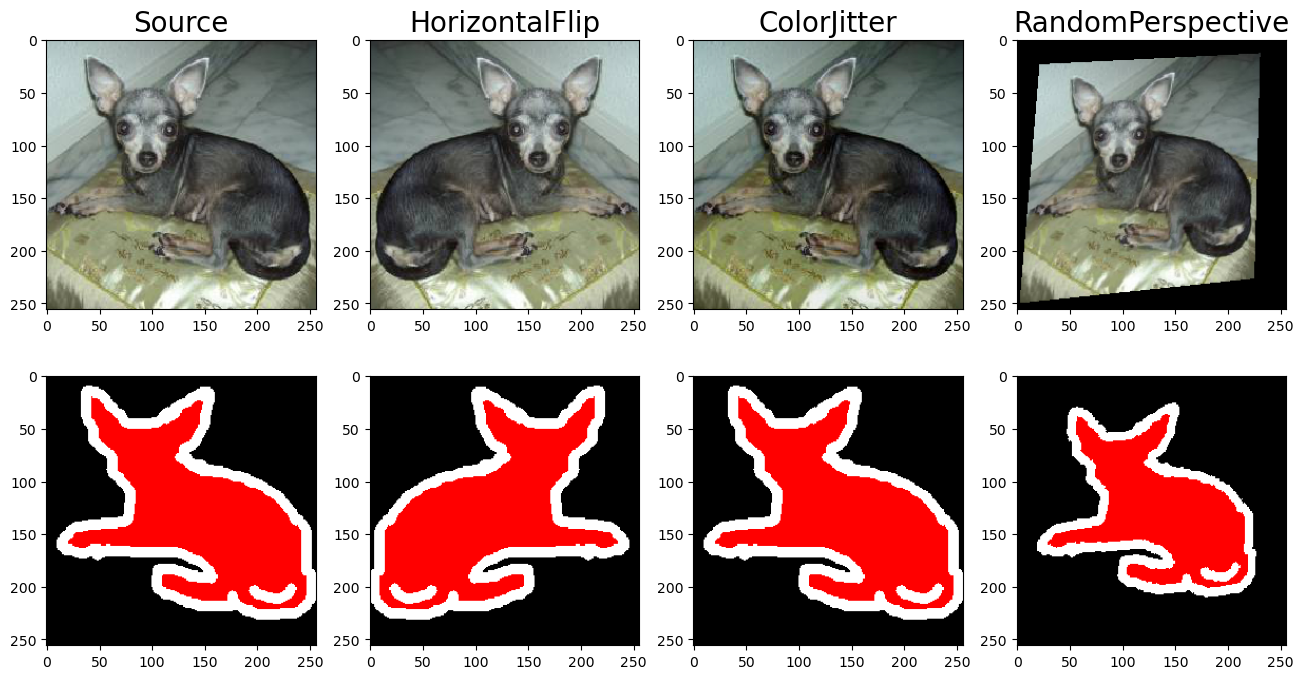

In [9]:
img_idx = np.random.randint(0, 100)
f, ax = plt.subplots(2, 4, figsize=(16, 8))
pair = train_data_hdf5[img_idx]

imgs2draw = {"Source": pair,
            "HorizontalFlip": HorizontalFlip(1.0)(pair),
            "ColorJitter": ColorJitter(1.0, (0.4, 0.4, 0.4))(pair),
            "RandomPerspective": RandomPerspective(1.0, 0.25)(pair)
}
for idx, (name, pair) in enumerate(imgs2draw.items()):
    ax[0, idx].imshow(pair[0])
    ax[0, idx].set_title(name, fontsize=20)
    ax[1, idx].imshow(colorize(np.array(pair[1])))

plt.show()

Next, we describe our `SegmentationData` class and the operations of reducing images of type PIL.Image to pytorch tensors with ImageNet `normalization`. ImageNet normalization is a special case of [Standard normalization](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html), in which the per-channel average (red, green, blue color channels) and per-channel RMS deviations were calculated on [a huge sample of images](https://en.wikipedia.org/wiki/ImageNet).

Answer the question: `Why do we need to apply normalization to images?`

Your answer: ...

In [10]:
# Determine the device for computing (!preferably GPU!)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

t_dict = {
    "forward_input": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]),
    "backward_input": transforms.Compose([
        transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                     std=[1./0.229, 1./0.224, 1./0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                     std=[1.0, 1.0, 1.0]),
        transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
    ]),
    "forward_target": transforms.Compose([
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.long().squeeze().to(DEVICE)),
    ]),
    "backward_target": transforms.Compose([
        transforms.Lambda(lambda x: x.cpu().numpy())
    ]),
    "augment": transforms.Compose([
        HorizontalFlip(0.5),
        ColorJitter(0.5, (0.4, 0.4, 0.4)),
        RandomPerspective(0.5, 0.25)
    ]),
}


class SegmentationDataset(Dataset):
    def __init__(self, dataset_raw: Type[storage_class], transforms: dict, train_flag: bool = True):
        """
        We inherit all the functionality from `Dataset` for our data `dataset_raw`
        `transforms` contains PIL.Image -> torch.tensor transformations and augmentations
        `train_flag` controls data augmentation (it is not needed for the test sample)
        """
        super().__init__()
        self.dataset_raw = dataset_raw
        self.transforms = transforms
        self.train_flag = train_flag

    def __len__(self):
        return self.dataset_raw.dataset_size

    def __getitem__(self, idx: int) -> tuple[Image_t, Image_t]:
        input, target = self.dataset_raw[idx]

        if (self.train_flag):
            input, target = self.transforms["augment"]((input, target))

        return self.transforms["forward_input"](input), self.transforms["forward_target"](target)

In [11]:
from torch.utils.data import random_split

# We divide the training set into training and validation
def split_train_val(train_data: Type[storage_class], train_portion: float = 0.8):
    """
    `train_data` preprocessed data
    `train_portion` the proportion of objects that will fall in the training set
    """
    trainval_dataset = SegmentationDataset(train_data, t_dict, train_flag=True)

    train_size = int(len(trainval_dataset) * train_portion)
    val_size = len(trainval_dataset) - train_size
    return random_split(trainval_dataset, [train_size, val_size])

train_dataset_hdf5, val_dataset_hdf5 = split_train_val(train_data_hdf5)
train_dataset_memmap, val_dataset_memmap = split_train_val(train_data_memmap)
train_dataset_raw, val_dataset_raw = split_train_val(train_data_raw)

Let's draw a random image (after applying random augmentation transformations):

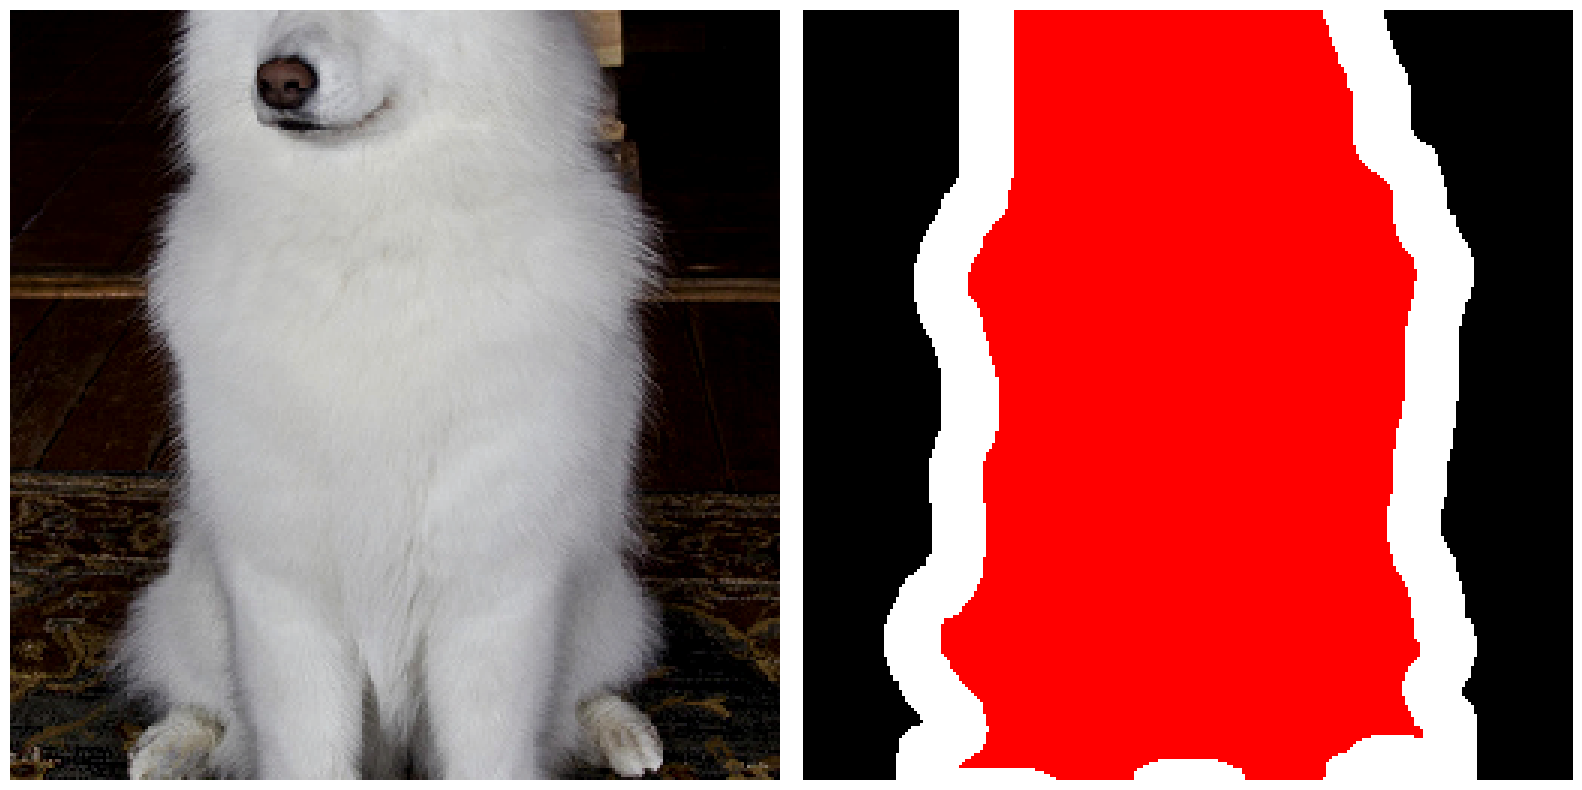

In [12]:
img_idx = np.random.randint(0, 100)
draw(train_dataset_hdf5[img_idx], t_dict);

In [13]:
dataloader_config = {
    "batch_size": 16, # Your value
    "shuffle": True,
    "num_workers": 0
}
train_dataloader_hdf5 = DataLoader(train_dataset_hdf5, **dataloader_config)
val_dataloader_hdf5 = DataLoader(val_dataset_hdf5, **dataloader_config)

train_dataloader_memmap = DataLoader(train_dataset_memmap, **dataloader_config)
val_dataloader_memmap = DataLoader(val_dataset_memmap, **dataloader_config)

train_dataloader_raw = DataLoader(train_dataset_raw, **dataloader_config)
val_dataloader_raw = DataLoader(val_dataset_raw, **dataloader_config)

### 1.3 Measuring the speed of reading a dataset from disk (0.5 points)

Measure the reading time of our dataset for each storage format:

In [14]:
def speedtest(dataloader: Type[DataLoader]) -> None:
    for batch in dataloader:
        pass

In [ ]:
%timeit speedtest(train_dataloader_hdf5)

In [ ]:
%timeit speedtest(train_dataloader_memmap)

In [ ]:
%timeit speedtest(train_dataloader_raw)

In [ ]:
import time

def speedtest_once(dataloader):
    start = time.time()
    for i, batch in enumerate(dataloader):
        if i >= 10:  #10 batches
            break
    end = time.time()
    print(f"Time for 10 batches: {end - start:.2f}s")

In [16]:
speedtest_once(train_dataloader_hdf5) #19.63
speedtest_once(train_dataloader_memmap) #16.40
speedtest_once(train_dataloader_raw) #23.50

Time for 10 batches: 20.37s
Time for 10 batches: 16.00s
Time for 10 batches: 21.00s


Answer the question: `Which format turned out to be the most efficient in terms of speed? Why?`

Your answer: Memmap enables direct access to specific portions of large arrays stored on disk without loading the entire dataset into memory. This allows fast sequential reads and avoids redundant file-opening overhead. HDF5 introduces additional structural overhead due to its hierarchical file format, and the Raw format is slower because each image must be opened and decoded individually.

Create a test Dataloader of the winning format.

In [17]:
test_data_memmap = prepare_dataset(config_test, storage_memmap)
test_data_memmap.lock()

test_dataset_memmap = SegmentationDataset(test_data_memmap, t_dict, train_flag=False)

test_dataloader = DataLoader(
    test_dataset_memmap,
    batch_size=16,
    shuffle=False,
    num_workers=0
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:25<00:00,  3.18s/it]


## Part 2: Implementation of loss functions, metrics and PSPNet decoder

Previously, you were introduced to the Unet architecture, a convolutional autoencoder used in the field of image segmentation. In this task we will analyze a more advanced segmentation network architecture [PSPNet](https://arxiv.org/abs/1612.01105). A distinctive feature of this network is the `Pyramid Pooling Module`, which, unlike Unet, allows you to take into account the `global` context of an image when extracting features from its `local` areas.

Let's look at the proposed architecture of a `PSPNet-like network`:
[Image](https://drive.google.com/file/d/1AFGZHhC9qm25dmDKxtSZ-Pltx6pGypqw/view?usp=sharing)

We will use the pre-trained [ResNeXt](https://pytorch.org/hub/pytorch_vision_resnext/) network as the `Encoder`. We will use it to obtain two deep representations of our input image `x`:
- output `x_main` - "average" intermediate representation, a compromise between low-level features (color, object outlines, strokes) and high-level features (abstract features reflecting the semantics of the image)
- output `x_supp` - the final representation containing the highest-level features, in which information about the exact spatial location of objects is significantly lost

This splitting of the output into 2 streams is explained by the need for encoded information about the spatial location of objects (`x_main`) and auxiliary information about the semantics of the entire image as a whole (`x_supp`) for the task of semantic segmentation. We cannot afford to use only the `x_supp` output, as is done, for example, in classification problems, because we are required to have additional knowledge about the location of this object in the image.

Your task is to write a `Decoder`, namely to write blocks:
- `Pyramid Pooling Module`. Several pooling operations of different sizes are applied in parallel to the input tensor `x_main`, which reduce the spatial dimensions of the original tensor to sizes `1x1`, `2x2`, `3x3` and `6x6`. The intermediate tensor channels are effectively reduced (using `nn.Conv2d with a 1x1 filter size`) and then the spatial dimensions are interpolated to the original dimensions. This procedure is necessary to extract global context at different scales, which classical convolutional neural networks lack (local context within the filter size). Thus, the output tensor obtained by concatenating these global contexts contains information about the entire input tensor at different levels of granularity. Intermediate reduction of tensor channels is performed to compress information, as well as to individually weigh the global context of each scale. It is required to implement the `forward` stage of this block. To clarify the information, you can refer to [article](https://arxiv.org/abs/1612.01105).

- `Supplementary Module` performs a nonlinear transformation over the input tensor `x_supp` with a reduction in the number of channels to the dimension of the output of the `Pyramid Pooling Module`. An architecture option for this transformation (layer composition) has already been proposed, but if you wish, you can experiment with it
- `Upsample Module` performs nonlinear transformations over the input tensor with a decrease in the number of channels, which alternate with interpolation of spatial dimensions by 2 times (increase). Thus, the output of this block has the same spatial dimension as the image input to the encoder. This transformation (layers `Layer 0`, `Layer 1` and `Layer 2`) needs to be selected experimentally
- `Segmentation Head` non-linearly transforms the input tensor into a score tensor. We have that the output tensor for each pixel has `num_classes` scores (in our case 3). In the future, the index of the maximum score for a given pixel will be its class label (0, 1 or 2). This transformation (layer composition) needs to be selected experimentally

If the decoder turns out to be too big, then the `Concat` operator can be replaced with channel-by-channel summation. Please note that there is no single correct architecture for the above blocks. It is required to experimentally select it so as to obtain the best quality of segmentation at a reasonable complexity.

### 2.1 PSPNet-like network encoder and decoder (2.5 points)

In [18]:
from torchvision.models.resnet import ResNet

pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)

# Set evaluation mode (affects the behavior of layers such as BatchNorm2d, Dropout)
pretrained_model.eval();

Using cache found in /home/coder/.cache/torch/hub/pytorch_vision_v0.10.0
/home/coder/.conda/envs/gym/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coder/.conda/envs/gym/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Since the encoder is pre-trained, it is necessary to fix (freeze) the weights so that the gradient does not flow through them. This ensures that the encoder does not change during autoencoder training, and also saves computational resources (the encoder gradient graph is not saved).

In [19]:
class EncoderBlock(nn.Module):
    def __init__(self, pretrained_model: Type[ResNet]):
        """
        Retrieves the pretrained named encoder layers `pretrained_model`
        Separates layers into `main` and `supp` threads (see architecture above)

        Input: tensor (Batch_size, 3, Height, Width)

        Output: x_main tensor (Batch_size, 512, Height // 8, Width // 8)
        Output: x_supp tensor (Batch_size, 2048, Height // 32, Width // 32)
        """
        super().__init__()

        self.encoder_main = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[:-4]:
            print(f"Pretrained main module {name} is loaded")
            self.encoder_main.add_module(name, child)

        self.encoder_supp = nn.Sequential()
        for name, child in list(pretrained_model.named_children())[-4:-2]:
            print(f"Pretrained supp module {name} is loaded")
            self.encoder_supp.add_module(name, child)

    def freeze(self) -> None:
        """
        Freezes encoder's weights
        """
        for p in self.parameters():
            p.requires_grad = False
        self.eval()

    def unfreeze(self) -> None:
        """
        Unfreezes encoder's weights
        """
        for p in self.parameters():
            p.requires_grad = True
        self.train()

    def forward(self, x: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
        x_main = self.encoder_main(x)
        x_supp = self.encoder_supp(x_main)
        return x_main, x_supp

In [20]:
encoder = EncoderBlock(pretrained_model)

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded


To estimate the complexity of the model, we need a function for counting the number of its parameters; for this, use the `.parameters()` method. Implement it below:

It would also be useful to make sure that the `.parameters()` method returns what we expect it to. To do this, we will use the `.named_parameters()` method:

In [21]:
for name, parameter in encoder.named_parameters():
    print(name)

encoder_main.conv1.weight
encoder_main.bn1.weight
encoder_main.bn1.bias
encoder_main.layer1.0.conv1.weight
encoder_main.layer1.0.bn1.weight
encoder_main.layer1.0.bn1.bias
encoder_main.layer1.0.conv2.weight
encoder_main.layer1.0.bn2.weight
encoder_main.layer1.0.bn2.bias
encoder_main.layer1.0.conv3.weight
encoder_main.layer1.0.bn3.weight
encoder_main.layer1.0.bn3.bias
encoder_main.layer1.0.downsample.0.weight
encoder_main.layer1.0.downsample.1.weight
encoder_main.layer1.0.downsample.1.bias
encoder_main.layer1.1.conv1.weight
encoder_main.layer1.1.bn1.weight
encoder_main.layer1.1.bn1.bias
encoder_main.layer1.1.conv2.weight
encoder_main.layer1.1.bn2.weight
encoder_main.layer1.1.bn2.bias
encoder_main.layer1.1.conv3.weight
encoder_main.layer1.1.bn3.weight
encoder_main.layer1.1.bn3.bias
encoder_main.layer1.2.conv1.weight
encoder_main.layer1.2.bn1.weight
encoder_main.layer1.2.bn1.bias
encoder_main.layer1.2.conv2.weight
encoder_main.layer1.2.bn2.weight
encoder_main.layer1.2.bn2.bias
encoder_main

In [22]:
def count_parameters(model: nn.Module) -> int:
    total_params = 0
    for p in model.parameters():
        if p.requires_grad:
            total_params += p.numel()
    return total_params

Let's make sure that the `.freeze()` method successfully freezes the weights:

In [23]:
print("Encoder #parameters before freeze():", count_parameters(encoder))
encoder.freeze()
print("Encoder #parameters after freeze():", count_parameters(encoder))

Encoder #parameters before freeze(): 22979904
Encoder #parameters after freeze(): 0


22 m params cool)

Implement `PyramidPoolingModule`, `Upsample` and `SegmentationHead` (0.5 points each), and fill in the missing `???` values in `UpsampleModule` and `DecoderBlock` (0.25 points each). The choice of network parameters/architecture largely depends on the learning outcomes in the next part of the assignment (so you will return to this point).

In [28]:
class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...]):
        super().__init__()
        self.bins = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(bin_size),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            for bin_size in bin_sizes
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h, w = x.shape[2:]
        out = []
        for p in self.bins:
            y = p(x)
            y = F.interpolate(y, size=(h, w), mode='bilinear', align_corners=False)
            out.append(y)
        return torch.cat([x] + out, dim=1)


class SupplementaryModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float):
        super().__init__()
        self.suppl = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels // 2),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(in_channels // 2, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.suppl(x)


class Upsample(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.us_transform = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.us_transform(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        return x


class UpsampleModule(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        c1 = in_channels // 2
        c2 = max(1, in_channels // 4)
        self.upsample = nn.Sequential(
            Upsample(in_channels, c1),
            Upsample(c1, c2),
            Upsample(c2, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(x)

In [29]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, bin_sizes: tuple[int, ...], dropout: float = 0.1):
        super().__init__()
        assert in_channels % len(bin_sizes) == 0

        self.PPM = PyramidPoolingModule(in_channels, in_channels // len(bin_sizes), bin_sizes)
        self.SM  = SupplementaryModule(4 * in_channels, in_channels, dropout)
        self.UM  = UpsampleModule(3 * in_channels, out_channels)

    def forward(self, x_main: torch.Tensor, x_supp: torch.Tensor) -> torch.Tensor:
        h_supp, w_supp = x_supp.shape[2:]
        x_supp = F.interpolate(input=x_supp, size=(4 * h_supp, 4 * w_supp), mode='bilinear', align_corners=True)

        x_supp = self.SM(x_supp)
        x_main = self.PPM(x_main)

        out = self.UM(torch.cat([x_main, x_supp], dim=1))
        return out


class SegmentationHead(nn.Module):
    def __init__(self, in_channels: int, num_classes: int, dropout: float):
        super().__init__()
        mid = max(16, in_channels // 2)
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(in_channels, mid, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(mid, num_classes, kernel_size=1)
        )

    def forward(self, x: torch.Tensor, x_supp: torch.Tensor) -> torch.Tensor:
        return self.segmentation_head(x)

### 2.2 Implementation of metrics (3.5 points)

In the segmentation task, the following metrics are mainly used to assess the predictive ability of a neural network:

Let $\mathrm{P}$ denotes the predicted segmentation masks, $\mathrm{S}$ denotes the scores for each class of segmentation mask, and $\mathrm{T}$ denotes the target segmentation mask. Then:

- Intersection over Union metric (Jaccard index):
$$
\mathrm{IoU}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij}*T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} [P_{ij} + T_{ij} - P_{ij}*T_{ij}]}\text{, where } P, T \in \{0, 1\}^{M \times N}
$$
- Recall metric:
$$
\mathrm{Recall}(P, T) = \dfrac{\sum_{i=1}^{M}\sum_{j=1}^{N}[P_{ij} * T_{ij}]}{\sum_{i=1}^{M}\sum_{j=1}^{N} T_{ij}}\text{, where } P, T \in \{0, 1\}^{M \times N}
$$
The above metrics are described for the case of binary segmentation, which is not suitable for us. Let's generalize them to the case of multiclass segmentation: imagine a K-class problem as K two-class ones, and then `macro` or `micro` average the metrics for them. You need to implement multi-class versions of the specified metrics with support for macro- and micro-averaging (1 point each). Please note that metrics are calculated for each element from the batch. The `reduce` argument is responsible for reducing metrics along the batch dimension (see below).

We will also use two different but similar loss functions for training:
- Cross Entropy Loss:
$$
\mathrm{CE}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big]\text{, where } S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}
$$
- [Focal Loss](https://arxiv.org/abs/1708.02002):
$$
\mathrm{FL}(S, T) = - \dfrac{1}{MN}\sum_{c=1}^{K}\sum_{i=1}^{M}\sum_{j=1}^{N} \big[(1 - \mathrm{Softmax}(S)_{cij})^{\gamma}*\log \mathrm{Softmax}(S)_{cij}*\mathbb{I}[T_{ij} == c]\big],
$$
where $S \in \mathbb{R}^{K \times M \times N}, T \in \{1, ..., K\}^{M \times N}, \gamma \in \mathbb{R}_{+}$ – hyperparameter.


It is not required to implement loss functions. Also, it is necessary to ensure correct processing of `ignore_index` values, which in our case are equal to 255 (do not participate in the calculation of metrics/loss functions). If representatives of some classes are absent in $\mathrm{T}$, then there is no need to take these classes into account during macro-averaging.

In [30]:
class MetricsCollection():
    def __init__(self, num_classes: int, ignore_index: int = 255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def IoUMetric(
        self, prediction: torch.Tensor, target: torch.Tensor,
        average: str = "macro", reduce: str = "mean"
    ) -> Union[torch.Tensor, float]:
        """
        `prediction` predicted segmentation mask of size (B, H, W)  -- class indices
        `target`     ground-truth segmentation mask of size (B, H, W) -- class indices
        """
        assert average in ["micro", "macro"]
        assert reduce in ["sum", "mean", "none"]

        B = prediction.shape[0]
        vals = []

        for b in range(B):
            pred = prediction[b]
            true = target[b]

            valid = true != self.ignore_index
            pred = pred[valid]
            true = true[valid]

            if true.numel() == 0:
                vals.append(torch.tensor(0.0, device=pred.device))
                continue

            if average == "macro":
                per_class = []
                for c in range(self.num_classes):
                    inter = ((pred == c) & (true == c)).sum().float()
                    union = ((pred == c) | (true == c)).sum().float()
                    if union == 0:
                        continue
                    per_class.append(inter / union)
                if len(per_class) == 0:
                    vals.append(torch.tensor(0.0, device=pred.device))
                else:
                    vals.append(torch.mean(torch.stack(per_class)))
            else:  # micro
                inter_total = sum(((pred == c) & (true == c)).sum() for c in range(self.num_classes))
                union_total = sum(((pred == c) | (true == c)).sum() for c in range(self.num_classes))
                vals.append((inter_total.float() / union_total.float()) if union_total > 0 else torch.tensor(0.0, device=pred.device))

        vals = torch.stack(vals)
        if reduce == "sum":
            return vals.sum()
        elif reduce == "mean":
            return vals.mean()
        else:
            return vals

    def RecallMetric(
        self, prediction: torch.Tensor, target: torch.Tensor,
        average: str = "macro", reduce: str = "mean"
    ) -> Union[torch.Tensor, float]:
        """
        `prediction` predicted segmentation mask of size (B, H, W)
        `target`     ground-truth segmentation mask of size (B, H, W)
        """
        assert average in ["micro", "macro"]
        assert reduce in ["sum", "mean", "none"]

        B = prediction.shape[0]
        vals = []

        for b in range(B):
            pred = prediction[b]
            true = target[b]

            valid = true != self.ignore_index
            pred = pred[valid]
            true = true[valid]

            if true.numel() == 0:
                vals.append(torch.tensor(0.0, device=pred.device))
                continue

            if average == "macro":
                per_class = []
                for c in range(self.num_classes):
                    tp = ((pred == c) & (true == c)).sum().float()
                    fn = ((pred != c) & (true == c)).sum().float()
                    denom = tp + fn
                    if denom == 0:
                        continue
                    per_class.append(tp / denom)
                if len(per_class) == 0:
                    vals.append(torch.tensor(0.0, device=pred.device))
                else:
                    vals.append(torch.mean(torch.stack(per_class)))
            else:  # micro
                tp_total = sum(((pred == c) & (true == c)).sum() for c in range(self.num_classes))
                fn_total = sum(((pred != c) & (true == c)).sum() for c in range(self.num_classes))
                denom = (tp_total + fn_total).float()
                vals.append((tp_total.float() / denom) if denom > 0 else torch.tensor(0.0, device=pred.device))

        vals = torch.stack(vals)
        if reduce == "sum":
            return vals.sum()
        elif reduce == "mean":
            return vals.mean()
        else:
            return vals

    def FocalLoss(
        self, scores: torch.Tensor, target: torch.Tensor,
        reduce: str = "mean", gamma: float = 1.
    ) -> Union[torch.Tensor, float]:
        """
        `scores` (B, C, H, W) raw logits
        `target` (B, H, W) class indices
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        ce_loss = F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")
        coef = (1 - torch.exp(-ce_loss))**gamma
        focal_loss = coef * ce_loss
        norm = (focal_loss.numel() - (target == self.ignore_index).sum())

        if (reduce == "sum"):
            return focal_loss.sum() / norm * scores.shape[0]
        elif (reduce == "mean"):
            return focal_loss.sum() / norm
        else:
            return focal_loss.sum(dim=[1, 2]) / norm * scores.shape[0]

    def CrossEntropyLoss(
        self, scores: torch.Tensor, target: torch.Tensor, reduce: str = "mean"
    ) -> Union[torch.Tensor, float]:
        """
        `scores` (B, C, H, W) raw logits
        `target` (B, H, W) class indices
        """
        assert scores.shape[1] == self.num_classes
        assert reduce in ["sum", "mean", "none"]

        if (reduce == "sum"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean") * scores.shape[0]
        elif (reduce == "mean"):
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="mean")
        else:
            return F.cross_entropy(scores, target, ignore_index=self.ignore_index, reduction="none")

    @classmethod
    def ListMetrics(cls):
        return [method for method in dir(cls) if (method.endswith("Metric"))]

    @classmethod
    def ListLosses(cls):
        return [method for method in dir(cls) if (method.endswith("Loss"))]


In [31]:
metric_class = MetricsCollection(num_classes=3, ignore_index=255)

prediction = torch.tensor([[[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 1, 0], [0, 0, 0, 0]],
                           [[0, 0, 0, 0], [0, 2, 2, 0], [0, 2, 0, 0], [0, 0, 0, 0]]])

target = torch.tensor([[[0, 0, 0, 0], [0, 1, 255, 0], [0, 1, 255, 0], [0, 0, 0, 0]],
                       [[0, 0, 0, 0], [0, 255, 2, 0], [0, 255, 2, 0], [0, 0, 0, 0]]])

assert np.isclose(metric_class.RecallMetric(prediction, target, "micro", "mean").item(), 0.9286, atol=1e-3)
assert np.isclose(metric_class.RecallMetric(prediction, target, "macro", "mean").item(), 0.7500, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "micro", "mean").item(), 0.8667, atol=1e-3)
assert np.isclose(metric_class.IoUMetric(prediction, target, "macro", "mean").item(), 0.7115, atol=1e-3)

Answer the question (No. 1): `What does the situation say about the predictive ability of our network: high Recall and low IoU for some class? Is the reverse situation possible?`

Your answer: High recall with low IoU means the model captures most of the true pixels of a class (few false negatives) but also predicts many extra pixels that don’t belong to the class (many false positives), i.e., it over-segments. The reverse—low recall with high IoU—doesn’t really happen: if recall is low, false negatives are large, which necessarily drags IoU down; high IoU generally requires both reasonably high recall and precision

Answer the question (No. 2): `Which type of averaging is more correct to use in our problem: macro and micro? Why?`

Your answer: In this segmentation task the classes are imbalanced because of background dominates. Macro averaging, which computes the metric per class and then averages, is more appropriate because it gives minority classes equal influence and reflects performance on cat/dog fairly. Micro averaging pools all pixels across classes and is dominated by the background, so it can look optimistic while the network performs poorly on the smaller classes.

Answer question (No. 3): `What is the advantage of Focal Loss over Cross Entropy Loss? What does the hyperparameter 𝛾 control in Focal Loss?`

Your answear: Focal Loss improves over Cross-Entropy by down-weighting easy, well-classified pixels and concentrating the gradient on hard or minority-class pixels, which helps under class imbalance. The hyperparameter γ (“gamma”) controls that focusing: γ=0 reduces to standard Cross-Entropy, and larger γ increases the emphasis on hard examples by further reducing the contribution of easy ones

## Part 3: PSPNet training, experiments

Now all that remains is to put everything that was written earlier together and train our network. To control the learning process of our network, we will calculate average metrics and loss functions on the validation set. For the convenience of displaying information, we will use the `tensorboard` tool. To do this, let's create an object of the `SummaryWriter` class, which will create and open for writing a special `event` file for [tensorboard](https://pytorch.org/docs/stable/tensorboard.html). To visualize the content, enter the command `tensorboard --logdir=<PATH>` in the terminal. If there is a need to monitor several tensorboards, then each of them needs to be assigned its own unique port `--port <PORT>`. [Example](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb#scrollTo=lFKETpE2F2oE) of using tensorboard on Google Colab.

You need to write the `train_model` and `test_model` methods. All training configuration is stored in the `train_config` dictionary. If desired, you can supplement it with something of your own.

You will need to attach tensorboard logs to your solution. To facilitate the verification procedure, it is strongly recommended to use `inline-tensorboard`:

```
%load_ext tensorboard
%tensorboard --logdir ./runs
```

### 3.1 Implementation of network training/testing procedures (1 point)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import wandb
from typing import Type
import os

In [39]:
class PSPNet(nn.Module):
    def __init__(
        self, pretrained_model: Type[ResNet], HeadBlock: Type[nn.Module],
        num_classes: int, train_config: dict, bin_sizes: tuple[int, ...]=(1, 2, 3, 6)
    ):
        super().__init__()
        # ----- encoder (frozen) -----
        self.encoder = EncoderBlock(pretrained_model)
        self.encoder.freeze()

        # Decoder: output 128 channels; Head consumes 128 → num_classes
        self.decoder = DecoderBlock(512, 128, bin_sizes)
        self.head = HeadBlock(128, num_classes, dropout=train_config.get("dropout", 0.3))

        # ----- training config -----
        self.train_config = train_config
        self.metric_class = train_config["metric_class"]
        self.optimizer = train_config["optimizer"](self.parameters(), **train_config["optimizer_params"])
        self.scheduler = train_config["scheduler"](self.optimizer, **train_config["scheduler_params"])

        # extras you referenced later
        self.loss_name = train_config.get("loss_name", "CrossEntropyLoss")  # or "FocalLoss"
        self.use_wandb = train_config.get("use_wandb", True)
        self.device = train_config.get("device", "cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # keep encoder grad-free
        with torch.no_grad():
            x_main, x_supp = self.encoder(x)
        out = self.decoder(x_main, x_supp)      # features
        out = self.head(out, x_supp)            # logits (B, C, H, W)
        return out, torch.argmax(out.detach(), dim=1)

    # --------- validation helpers ----------
    def _log_val_metrics(self, agg: dict[str, torch.Tensor], step: int, norm: int) -> None:
        if not self.use_wandb:
            return
        wandb.log({f"val/{k}": (v.item() / norm) for k, v in agg.items()}, step=step)

    def validate_model(self, val_dataloader: DataLoader, step: int) -> None:
        self.decoder.eval()
        self.head.eval()

        names = self.metric_class.ListMetrics() + self.metric_class.ListLosses()
        totals = {k: torch.tensor(0.0, device=self.device) for k in names}

        with torch.no_grad():
            for inp, tgt in val_dataloader:
                inp = inp.to(self.device, non_blocking=True)
                tgt = tgt.to(self.device, non_blocking=True)

                scores, pred = self.forward(inp)

                for m in self.metric_class.ListMetrics():
                    totals[m] += getattr(self.metric_class, m)(pred, tgt, reduce="sum")
                for l in self.metric_class.ListLosses():
                    totals[l] += getattr(self.metric_class, l)(scores, tgt, reduce="sum")

        if self.use_wandb:
            fig = draw((inp[0], tgt[0]), t_dict, pred[0], log=True)
            wandb.log({"val/image_gt_pred": wandb.Image(fig)}, step=step)

        self._log_val_metrics(totals, step=step, norm=len(val_dataloader.dataset))

        self.decoder.train()
        self.head.train()

    # --------- training ----------
    def train_model(self, train_dataloader: DataLoader, val_dataloader: DataLoader) -> None:
        self.decoder.train()
        self.head.train()

        validate_each_iter = self.train_config["validate_each_iter"]
        num_epochs = self.train_config["num_epochs"]
        save_path = self.train_config["save_model_path"]
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        global_step = 0
        for epoch in range(num_epochs):
            for it, (inp, tgt) in enumerate(train_dataloader):
                inp = inp.to(self.device, non_blocking=True)
                tgt = tgt.to(self.device, non_blocking=True)

                self.optimizer.zero_grad()
                scores, _ = self.forward(inp)
                loss = getattr(self.metric_class, self.loss_name)(scores, tgt, reduce="mean")
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()   # per-iteration StepLR (set step_size accordingly)

                if self.use_wandb:
                    wandb.log(
                        {"train/loss": loss.item(),
                         "train/lr": self.optimizer.param_groups[0]["lr"],
                         "train/epoch": epoch},
                        step=global_step
                    )

                if it % validate_each_iter == 0:
                    print(f"Epoch {epoch+1}/{num_epochs} | Iter {it}/{len(train_dataloader)} | Loss {loss.item():.4f}")
                    self.validate_model(val_dataloader, step=global_step)

                global_step += 1

            torch.save(self.state_dict(), f"{save_path}_{epoch+1}.pth")

    # --------- inference ----------
    def test_model(self, test_dataloader: DataLoader) -> tuple[torch.Tensor, torch.Tensor]:
        self.decoder.eval()
        self.head.eval()

        preds, gts = [], []
        with torch.no_grad():
            for inp, tgt in test_dataloader:
                inp = inp.to(self.device, non_blocking=True)
                tgt = tgt.to(self.device, non_blocking=True)
                _, pred = self.forward(inp)
                preds.append(pred.cpu())
                gts.append(tgt.cpu())

        dl_prediction = torch.cat(preds, dim=0)
        dl_target = torch.cat(gts, dim=0)
        return dl_prediction, dl_target


In [46]:
import wandb
wandb.finish()

In [47]:
import os
os.environ["WANDB_DISABLED"] = "true"  # safest
# or:
# os.environ["WANDB_MODE"] = "offline"
import wandb

In [49]:
from torch.optim.lr_scheduler import StepLR

wandb.init(project="segmentation-pspnet", name="retry_run", mode="offline")
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_PATH = "/home/coder/project/Segmentation_Task/checkpoints"

train_config = {
    "num_epochs": 5,
    "dropout" : 0.5,
    "optimizer": torch.optim.Adam,
    "optimizer_params": {"lr": 1e-3, "weight_decay": 1e-5},
    "scheduler": StepLR,
    # StepLR here is stepped *each iteration* in PSPNet; step_size counts iterations
    "scheduler_params": {"step_size": 50, "gamma": 0.85},
    "validate_each_iter": 10,
    "save_model_path": SAVE_PATH,
    "metric_class": MetricsCollection(num_classes=3, ignore_index=255),
    "loss_name": "CrossEntropyLoss",   # or "FocalLoss"
    "use_wandb": True,
    "device": DEVICE,
}

socket.send() raised exception.
socket.send() raised exception.


BrokenPipeError: [Errno 32] Broken pipe

In [37]:
net = PSPNet(pretrained_model, SegmentationHead, num_classes=3,train_config=train_config).to(DEVICE)
print("#params:", count_parameters(net))

Pretrained main module conv1 is loaded
Pretrained main module bn1 is loaded
Pretrained main module relu is loaded
Pretrained main module maxpool is loaded
Pretrained main module layer1 is loaded
Pretrained main module layer2 is loaded
Pretrained supp module layer3 is loaded
Pretrained supp module layer4 is loaded


TypeError: SegmentationHead.__init__() missing 1 required positional argument: 'dropout'